In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import lmfit as lm
import mplstylize as scimpl
from enum import Enum

%config InlineBackend.figure_format = 'retina'

In [17]:
blue = list(plt.rcParams["axes.prop_cycle"])[0]["color"]
red = list(plt.rcParams["axes.prop_cycle"])[1]["color"]

## Temperature dependence

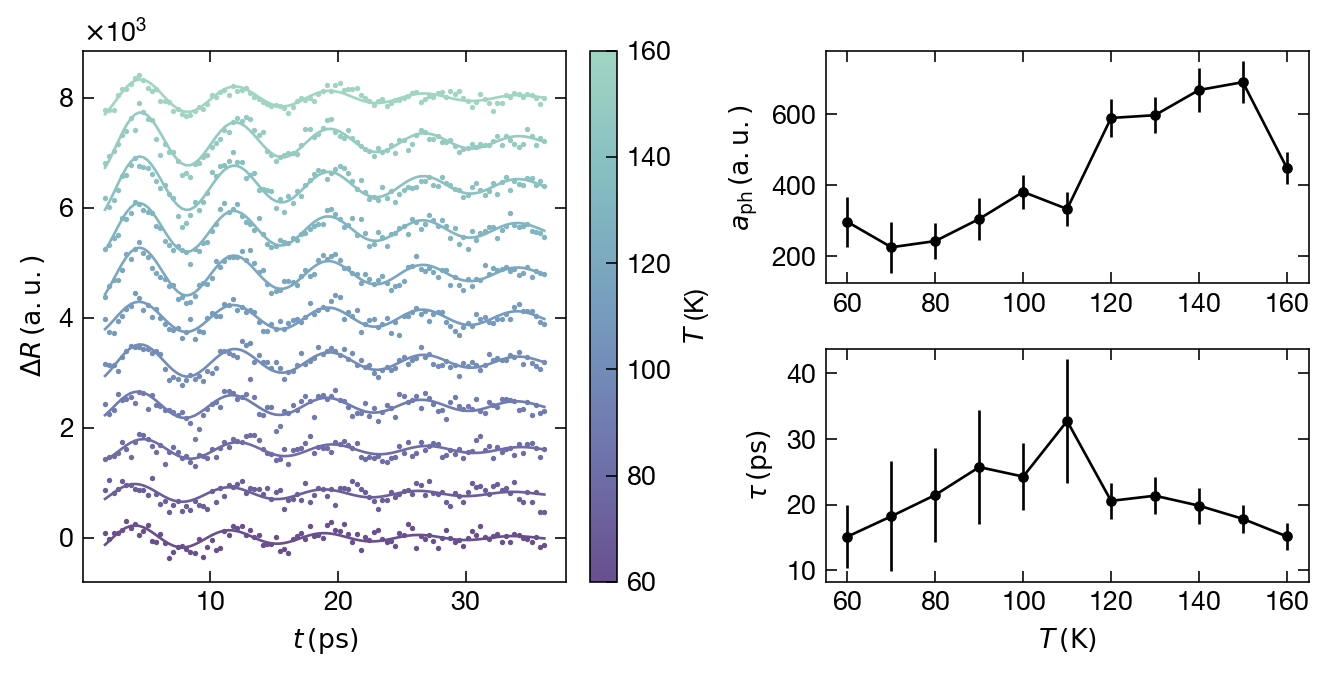

In [18]:
df = pd.read_csv("Data/temp_dep.csv", skiprows=2)
df.rename(
    columns={"Unnamed: 0": "Delay (mm)", "Unnamed: 1": "Delay (ps)"}, inplace=True
)

temp = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
delay = df.iloc[:, 1] + 2.8
idx = slice(37, 141)


def damped_cos(x, amp, freq, shift, damp):
    return amp * np.cos(x * freq + shift) * np.exp(-x / damp)


model = lm.Model(damped_cos)
pars = model.make_params(amp=500, freq=0.85, shift=np.pi / 2, damp=20)
pars["freq"].set(vary=False)

with plt.style.context({"xtick.major.size" : 4}):
        
    fig: plt.Figure = plt.figure(figsize=(6.8, 3.4))
    ax: dict[plt.Axes] = fig.subplot_mosaic(
        [["traces", "amplitude"], ["traces", "damping"]]
    )
    color_idx = np.linspace(0, 1, len(temp))
    cmap = scimpl.get_colormap("ocean")
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=temp[0], vmax=temp[-1])),
        ax=ax["traces"],
        label=r"$T$ (K)",
    )
    amplist, damplist, freqlist = [], [], []
    for i in range((len(temp))):
        y = df[str(temp[i])][idx]
        y -= np.mean(y[-10:])
        a, b, c = np.polyfit(delay[idx], y, deg=2)
        y -= a * delay[idx] ** 2 + b * delay[idx] + c

        result = model.fit(y, pars, x=delay[idx])
        damplist.append((result.params["damp"].value, result.params["damp"].stderr))
        amplist.append((result.params["amp"].value, result.params["amp"].stderr))
        freqlist.append((result.params["freq"].value, result.params["freq"].stderr))

        ax["traces"].scatter(delay[idx], 800 * i + y, color=cmap(color_idx[i]), s=1)
        ax["traces"].plot(
            delay[idx],
            800 * i + result.best_fit,
            c=cmap(color_idx[i]),
        )

    ax["traces"].set(xlabel=r"$t\,(\mathrm{ps})$", ylabel=r"$\Delta R\,(\mathrm{a.u.})$")

    ax["amplitude"].errorbar(
        temp,
        [a[0] for a in amplist],
        yerr=[a[1] for a in amplist],
        marker="o",
        color="black",
    )
    ax["amplitude"].set_ylabel(r"$a_{\mathrm{ph}}\,(\mathrm{a.u.})$ ")

    ax["damping"].errorbar(
        temp,
        [d[0] for d in damplist],
        yerr=[d[1] for d in damplist],
        marker="o",
        color="black",
    )
    ax["damping"].set(xlabel=r"$T\,(\mathrm{K})$", ylabel=r"$\tau\,(\mathrm{ps})$")

    # fig.savefig("Graphics/traces_v_temperature.pdf", format="pdf")
    # fig.savefig("Graphics/traces_v_temperature.png", format="png")

    plt.show()

## Power dependence

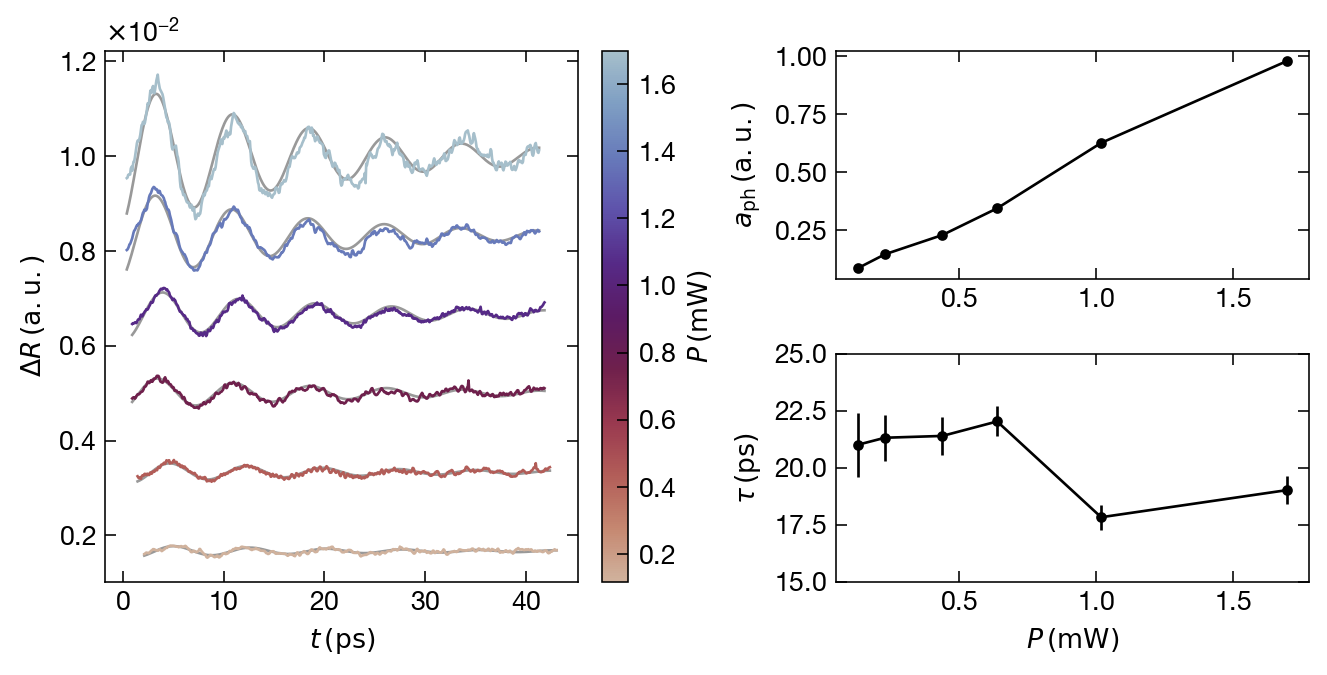

In [19]:
df = pd.read_csv("Data/fluence_dep.csv", skiprows=2)
df.rename(
    columns={
        "Unnamed: 0": "Delay (ps)",
        "Unnamed: 1": "Delay (ps)",
        "Unnamed: 2": "Delay (ps)",
        "Unnamed: 3": "Delay (ps)",
        "Unnamed: 4": "Delay (ps)",
        "Unnamed: 5": "Delay (ps)",
        "Unnamed: 6": "Delay (ps)",
        "Unnamed: 7": "Delay (ps)",
        "Unnamed: 8": "Delay (ps)",
        "Unnamed: 9": "Delay (ps)",
        "Unnamed: 10": "Delay (ps)",
    },
    inplace=True,
)
power = [1.70, 1.02, 0.64, 0.44, 0.23, 0.13]


def damped_cos(x, amp, freq, shift, damp):
    return amp * np.cos(x * freq + shift) * np.exp(-x / damp)


model = lm.Model(damped_cos)
pars = model.make_params(amp=2.0e-2, freq=0.83, shift=np.pi, damp=40)
pars["freq"].set(vary=False)

fig: plt.Figure = plt.figure(figsize=(6.8, 3.4))
ax: dict[plt.Axes] = fig.subplot_mosaic(
    [["traces", "amplitude"], ["traces", "damping"]]
)

color_idx = np.linspace(1, 0, len(temp))
cmap = scimpl.get_colormap("orange_blue")
cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=power[0], vmax=power[-1])),
    ax=ax["traces"],
    label=r"$P\,(\mathrm{mW})$",
)

amplist, damplist, freqlist = [], [], []
for i in range(0, len(temp) + 1, 2):
    y = df.iloc[:, i + 1]
    x = df.iloc[:, i]
    result = model.fit(y, pars, x=x)

    damplist.append((result.params["damp"].value, result.params["damp"].stderr))
    amplist.append((result.params["amp"].value, result.params["amp"].stderr))
    freqlist.append((result.params["freq"].value, result.params["freq"].stderr))
    ax["traces"].plot(
        df.iloc[:, i], 0.01 - i / 1200 + result.best_fit, c="k", alpha=0.4
    )
    ax["traces"].plot(x, 0.01 - i / 1200 + y, c=cmap(color_idx[i]))

ax["traces"].set(xlabel=r"$t\,(\mathrm{ps})$", ylabel=r"$\Delta R\,(\mathrm{a.u.})$")
ax["traces"].ticklabel_format(scilimits=(-2, 2), axis="y", useMathText=True)

ax["amplitude"].errorbar(
    power,
    [a[0] / 0.0016 for a in amplist],
    yerr=[a[1] for a in amplist],
    marker="o",
    color="black",
)
ax["amplitude"].set_ylabel(r"$a_\mathrm{ph}\,\mathrm{(a.u.)}$")

ax["damping"].errorbar(
    power,
    [d[0] for d in damplist],
    yerr=[d[1] for d in damplist],
    marker="o",
    color="black",
)
ax["damping"].set(xlabel=r"$P\,(\mathrm{mW})$", ylabel=r"$\tau\,\mathrm{(ps)}$", ylim=[15, 25])


plt.show()

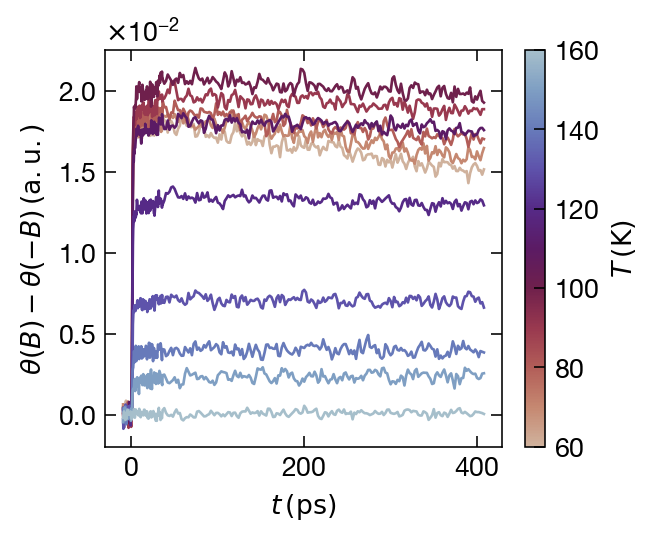

In [20]:
df = pd.read_csv("Data/a_minus_b_dynamics.csv", skiprows=2)
df.rename(
    columns={"Unnamed: 0": "Delay (mm)", "Unnamed: 1": "Delay (ps)"}, inplace=True
)

temp = [60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
delay = df.iloc[:, 1] + 3
idx = slice(3, -1)

fig, ax = plt.subplots(figsize=(3.4, 2.7))
ax.set_box_aspect(1)
color_idx = np.linspace(0, 1, len(temp))
# cbar = make_cbar(label="$T\,(\mathrm{K})$", vmin=temp[0], vmax=temp[-1])
for i in range((len(temp))):
    x = delay[idx]
    y = df[str(temp[i])][idx]
    y -= np.mean(y[:20])
    plt.plot(x, y, c=scimpl.get_colormap("orange_blue")(color_idx[i]))
cbar = plt.colorbar(
    plt.cm.ScalarMappable(
        cmap=scimpl.get_colormap("orange_blue"),
        norm=plt.Normalize(vmin=temp[0], vmax=temp[-1]),
    ),
    label=r"$T\,(\mathrm{K})$",
    ax=ax,
)
ax.ticklabel_format(scilimits=(-2, 2), axis="y", useMathText=True)
ax.set(xlabel=r"$t\,(\mathrm{ps})$", ylabel=r"$\theta(B)-\theta(-B)\,(\mathrm{a.u.})$")
plt.show()

## Sound and magnon dispersion

We assume a linear phonon dispersion, $ 2\pi f = v_s q $
$$ v_s = \lambda f_s = (2\pi/q_s) f_s $$


The magnon dispersion is set by the anisotropy gap $\Delta = 227.29\,\mathrm{GHz}$ and the magnon stiffness $D = 21036.51\,\mathrm{GHz}$ and follows
$$
     f = \Delta + Dq^2
$$
A damping of $20\,\mathrm{ps}$ corresponds to a $50\,\mathrm{GHz}$ broadening.

/var/folders/xj/bbkhcjcn0b142xcnlp_r44ph0000gn/T/ipykernel_39252/1482172240.py:19: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(


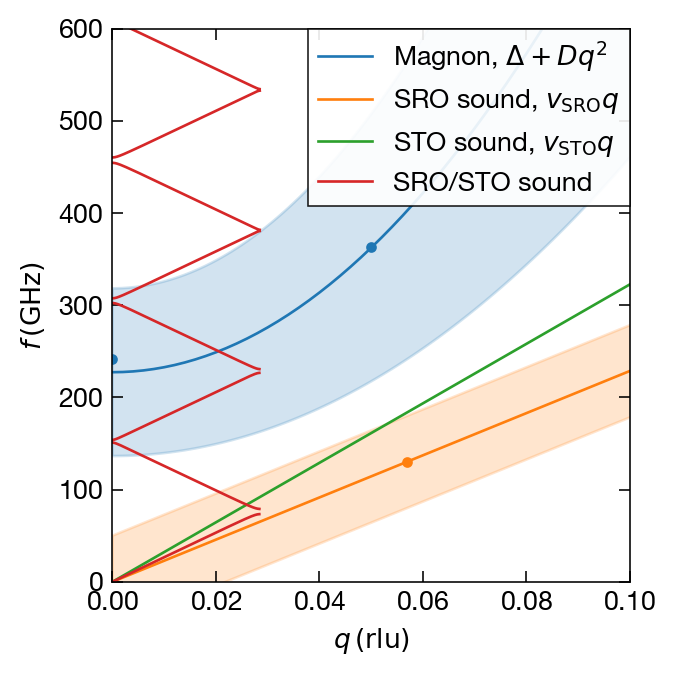

In [31]:
df = pd.read_csv("magnon_dispersion.txt")

fm = df.iloc[:, 1] * 241.80  # GHz
q = df.iloc[:, 0]
fdamp = 50  # GHz (40 ps)

d = 21.5  # Thickness, nm

fs = 130  # GHz frequency of standing wave
qs = np.pi / (d / 0.39)
vs = fs * (2 * np.pi / qs)

q_cont = np.linspace(0, 1, 1000)
fm_disp = 227.29 + 21036.51 / 0.39 * q_cont**2


def miniBZ_q(omega, v1, v2, rho1, rho2, d1, d2):
    kappa = (v2 * rho2) / (v1 * rho1)
    return np.arccos(
        (
            np.cos(omega * d1 / v1) * np.cos(omega * d2 / v2)
            - ((1 + kappa**2) / (2 * kappa))
            * np.sin(omega * d1 / v1)
            * np.sin(omega * d2 / v2)
        )
    ) / (d1 + d2)


omega_cont = 2 * np.pi * np.linspace(0, 2000, 100000)

v1, rho1, d1 = 7.9, 4.96, 21.5  # [nm/ps], [g/cm^2], [nm], STO
v2, rho2, d2 = 5.6, 6.20, 21.5  # [nm/ps], [g/cm^2], [nm], SRO

fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax.plot(q_cont, fm_disp, label=r"Magnon, $\Delta + Dq^2$")
ax.fill_between(
    x=q_cont, y1=fm_disp * (1 - 0.4), y2=fm_disp * (1 + 0.4), alpha=0.2, color=blue
)
ax.fill_between(
    x=q_cont,
    y1=vs * q_cont / (2 * np.pi) - 50,
    y2=vs * q_cont / (2 * np.pi) + 50,
    alpha=0.2,
    color=red,
)
ax.plot(
    q_cont,
    1e3 * 5.6 * (q_cont / 0.39) / (2 * np.pi),
    label=r"SRO sound, $v_\mathrm{SRO} q$",
)
ax.plot(
    q_cont,
    1e3 * 7.9 * (q_cont / 0.39) / (2 * np.pi),
    label=r"STO sound, $v_\mathrm{STO} q$",
)
ax.scatter(q, fm)
ax.scatter(qs, fs, c=red)

ax.plot(
    miniBZ_q(
        omega_cont, 1e3 * v1 / 0.39, 1e3 * v2 / 0.39, rho1, rho2, d1 / 0.39, d2 / 0.39
    ),
    omega_cont / (2 * np.pi),
    label="SRO/STO sound",
)

# plt.axvline(x=qs, c='k', ls='--', lw=.7)
ax.set(
    xlabel=r"$q\,(\mathrm{rlu})$",
    ylabel=r"$f\,(\mathrm{GHz})$",
    xlim=[0, 0.1],
    ylim=[0, 600],
)
legend = ax.legend(
    borderaxespad=0.0,
    bbox_to_anchor=(1, 1),
    loc="upper right",
    edgecolor="0",
)
frame = legend.get_frame()
frame.set_linewidth(0.6)


fig.savefig("Graphics/magnon_phonon_disp_folded.jpg", format="jpg")
plt.show()

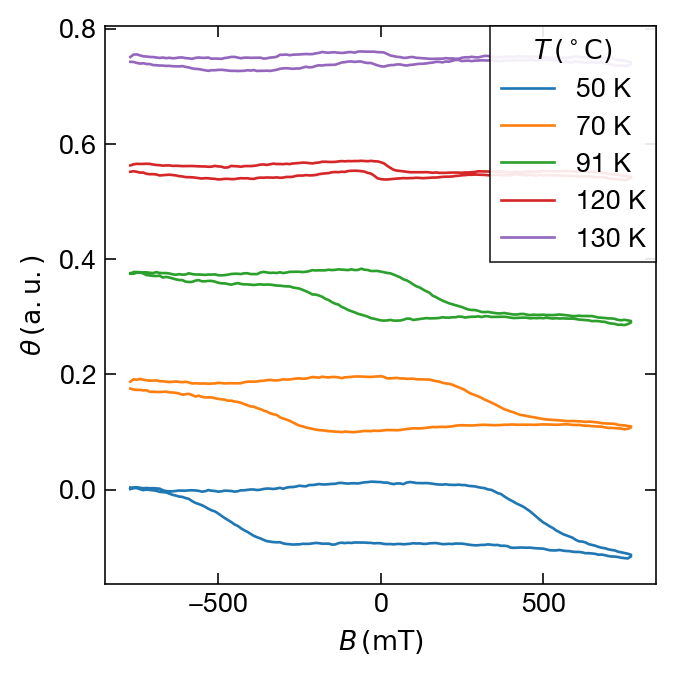

In [28]:
df = pd.read_csv("Data/hyst_flakes.csv")

# Set plotting context to rcParams["font.size"] = 10


# fmt: off
all_temps = [ 
    "50", "52", "54", "56", "58", 
    "60", "62", "64", "67", "70", 
    "73", "76", "79", "82", "85", 
    "88", "91", "94", "97", "100",
    "100.1", "102", "104", "106", "108", 
    "110", "112", "114", "116", "118",
    "120", "122", "124", "126", "128", 
    "130", "132", "134", "136", "138", 
    "140"
]
# fmt: on
temps = ["50", "70", "91", "120", "130"]

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
for i, T in enumerate(temps):
    a, b = np.polyfit(1000 * df["Field"][:50], df[T][:50], deg=1)
    offset = a * 1000 * df["Field"] + b
    ax.plot(
        1000 * df["Field"], 15 * (i / 80 + df[T] - offset), label="{} K".format(T)
    )
ax.set(xlabel=r"$B\,(\mathrm{mT})$", ylabel=r"$\theta\,(\mathrm{a.u.})$")
legend = ax.legend(
    borderaxespad=0.0,
    title=r"$T\,(^\circ\mathrm{C})$",
    bbox_to_anchor=(1, 1),
    loc="upper right",
    edgecolor="0",
)
frame = legend.get_frame()
frame.set_linewidth(0.6)


plt.savefig("flakes.pdf", format="pdf")
plt.show()